In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install mlflow-skinny==2.7.1
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2025.pkl'))

In [8]:
df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP_pg', 'FG_pg', 'FGA_pg',
       'FG%',
       ...
       'DBPM_rank', 'BPM_rank', 'VORP_rank', '%W', 'GT', '%W_rank', '%G',
       'Votes', 'Share', 'MaxVotes'],
      dtype='object', length=137)

In [9]:
df[df['Player'] == 'Shai Gilgeous-Alexander']

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
19117,Shai Gilgeous-Alexander,PG,20,LAC,82,73,26.5,4.2,8.7,0.476,...,40,71,41,0.585,82,25,1.000,0,0.000,1010
19808,Shai Gilgeous-Alexander,SG,21,OKC,70,70,34.7,6.8,14.5,0.471,...,38,43,19,0.611,72,12,0.972,0,0.000,1010
20456,Shai Gilgeous-Alexander,SG,22,OKC,35,35,33.7,8.2,16.1,0.508,...,38,27,29,0.306,72,75,0.486,0,0.000,1010
21189,Shai Gilgeous-Alexander,PG,23,OKC,56,56,34.7,8.5,18.8,0.453,...,46,39,19,0.293,82,97,0.683,0,0.000,1000
21956,Shai Gilgeous-Alexander,PG,24,OKC,68,68,35.5,10.4,20.3,0.510,...,28,12,5,0.488,82,41,0.829,46,0.046,1000
22429,Shai Gilgeous-Alexander,PG,25,OKC,75,75,34.0,10.6,19.8,0.535,...,25,9,4,0.695,82,2,0.915,640,0.646,990
23148,Shai Gilgeous-Alexander,PG,26,OKC,76,76,34.2,11.3,21.8,0.519,...,21,6,2,0.829,82,1,0.927,913,0.913,1000


In [10]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [11]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [12]:
df = pipe_clean.fit_transform(df)

In [13]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [14]:
len(df[df.index.get_level_values(1) > 2019]) / len(df)

0.17372466085521227

In [15]:
val_df = df[df.index.get_level_values(1) > 2019]
dev_df = df[df.index.get_level_values(1) <= 2019]

In [16]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [17]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21561 entries, 0 to 21560
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MP_pg   21561 non-null  float64
 1   FG_pg   21561 non-null  float64
 2   2P_pg   21561 non-null  float64
 3   FT_pg   21561 non-null  float64
 4   FTA_pg  21561 non-null  float64
 5   TRB_pg  21561 non-null  float64
 6   AST_pg  21561 non-null  float64
 7   STL_pg  21561 non-null  float64
 8   BLK_pg  21561 non-null  float64
 9   TOV_pg  21561 non-null  float64
 10  PTS_pg  21561 non-null  float64
 11  %GS     21561 non-null  float64
 12  PER     21561 non-null  float64
 13  USG%    21561 non-null  float64
 14  OWS     21561 non-null  float64
 15  DWS     21561 non-null  float64
 16  WS      21561 non-null  float64
 17  WS/48   21561 non-null  float64
 18  BPM     21561 non-null  float64
 19  VORP    21561 non-null  float64
 20  %W      21561 non-null  float64
 21  %G      21561 non-null  float64
dty

In [19]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [20]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [21]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [22]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [23]:
mlflow.set_experiment('LightGBM v2')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/9', creation_time=1732911721100, experiment_id='9', last_update_time=1732911721100, lifecycle_stage='active', name='LightGBM v2', tags={}>

In [24]:
param_grid = {
    'num_leaves': [50],
    'n_estimators': [130],
    'learning_rate': [.5],
    'max_depth': [3],
    'min_child_samples': [50]
    }

In [25]:
with mlflow.start_run():
    estimator = LGBMRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_lgbm(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_lgbm(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3531
[LightGBM] [Info] Number of data points in the train set: 19404, number of used features: 22
[LightGBM] [Info] Start training from score 0.051144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

2025/11/07 16:20:35 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2023-09-12; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'rapids-dask-dependency'}


In [26]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.012888,0.015905,0.030143
R2,0.993454,0.963985,0.696756


In [27]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [28]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.550181
LeBron James,2020,0.746,0.212106
James Harden,2020,0.363,0.541203
Luka Dončić,2020,0.198,0.203486
Kawhi Leonard,2020,0.166,0.092830
Anthony Davis,2020,0.081,0.017128
Chris Paul,2020,0.026,-0.008336
Damian Lillard,2020,0.023,0.231323
Nikola Jokić,2020,0.018,0.008670


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.692237
Joel Embiid,2021,0.580,0.390197
Stephen Curry,2021,0.449,0.021623
Giannis Antetokounmpo,2021,0.345,0.113966
Chris Paul,2021,0.138,0.015649
Luka Dončić,2021,0.042,0.301598
Damian Lillard,2021,0.038,-0.013761
Julius Randle,2021,0.020,0.009719
Derrick Rose,2021,0.010,0.000209


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.398021
Joel Embiid,2022,0.706,0.330114
Giannis Antetokounmpo,2022,0.595,0.475123
Devin Booker,2022,0.216,0.187288
Luka Dončić,2022,0.146,0.298257
Jayson Tatum,2022,0.043,0.123693
Ja Morant,2022,0.010,0.132632
Stephen Curry,2022,0.004,0.003223
Chris Paul,2022,0.002,0.098585


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.389414
Nikola Jokić,2023,0.674,0.563561
Giannis Antetokounmpo,2023,0.606,0.300154
Jayson Tatum,2023,0.280,0.123297
Shai Gilgeous-Alexander,2023,0.046,0.116839
Donovan Mitchell,2023,0.030,0.143767
Domantas Sabonis,2023,0.027,-0.001459
Luka Dončić,2023,0.010,0.256312
Stephen Curry,2023,0.005,0.024489


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.758842
Shai Gilgeous-Alexander,2024,0.646,0.473235
Luka Dončić,2024,0.572,0.647160
Giannis Antetokounmpo,2024,0.194,0.417024
Jalen Brunson,2024,0.143,0.047535
Jayson Tatum,2024,0.087,0.154124
Anthony Edwards,2024,0.018,0.168029
Domantas Sabonis,2024,0.003,0.131910
Kevin Durant,2024,0.001,0.005736


,,Share,PredShare
Player,Season,,
Shai Gilgeous-Alexander,2025,0.913,1.083655
Nikola Jokić,2025,0.787,0.588319
Giannis Antetokounmpo,2025,0.470,0.196703
Jayson Tatum,2025,0.311,0.181433
Donovan Mitchell,2025,0.074,0.012577
LeBron James,2025,0.016,0.101049
Anthony Edwards,2025,0.012,-0.016934
Cade Cunningham,2025,0.012,-0.067801
Stephen Curry,2025,0.002,-0.017205


No contenders results:


,,Share,PredShare
Player,Season,,
Bam Adebayo,2020,0.0,0.004547
Kyle Alexander,2020,0.0,0.000209
Nickeil Alexander-Walker,2020,0.0,0.000209
Grayson Allen,2020,0.0,0.000209
Jarrett Allen,2020,0.0,0.012917
...,...,...,...
Jesse Edwards,2025,0.0,0.000209
Mac McClung,2025,0.0,0.000209
Riley Minix,2025,0.0,0.000209


In [29]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Devin Booker,2021,0.0,0.131587
Donovan Mitchell,2021,0.0,0.247889
Deandre Ayton,2022,0.0,0.115591
Devin Booker,2023,0.0,0.102239
James Harden,2023,0.0,0.114304
Damian Lillard,2023,0.0,0.295586
Joel Embiid,2024,0.0,0.403731
Devin Booker,2024,0.0,0.122382
Victor Wembanyama,2024,0.0,0.149720


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

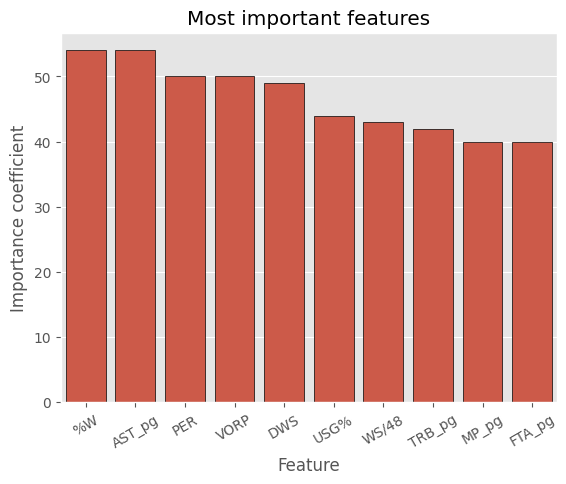

In [30]:
mod.display_feature_importances_lgbm(best_model)

In [31]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 6 Axes>, <Figure size 4000x4000 with 6 Axes>)

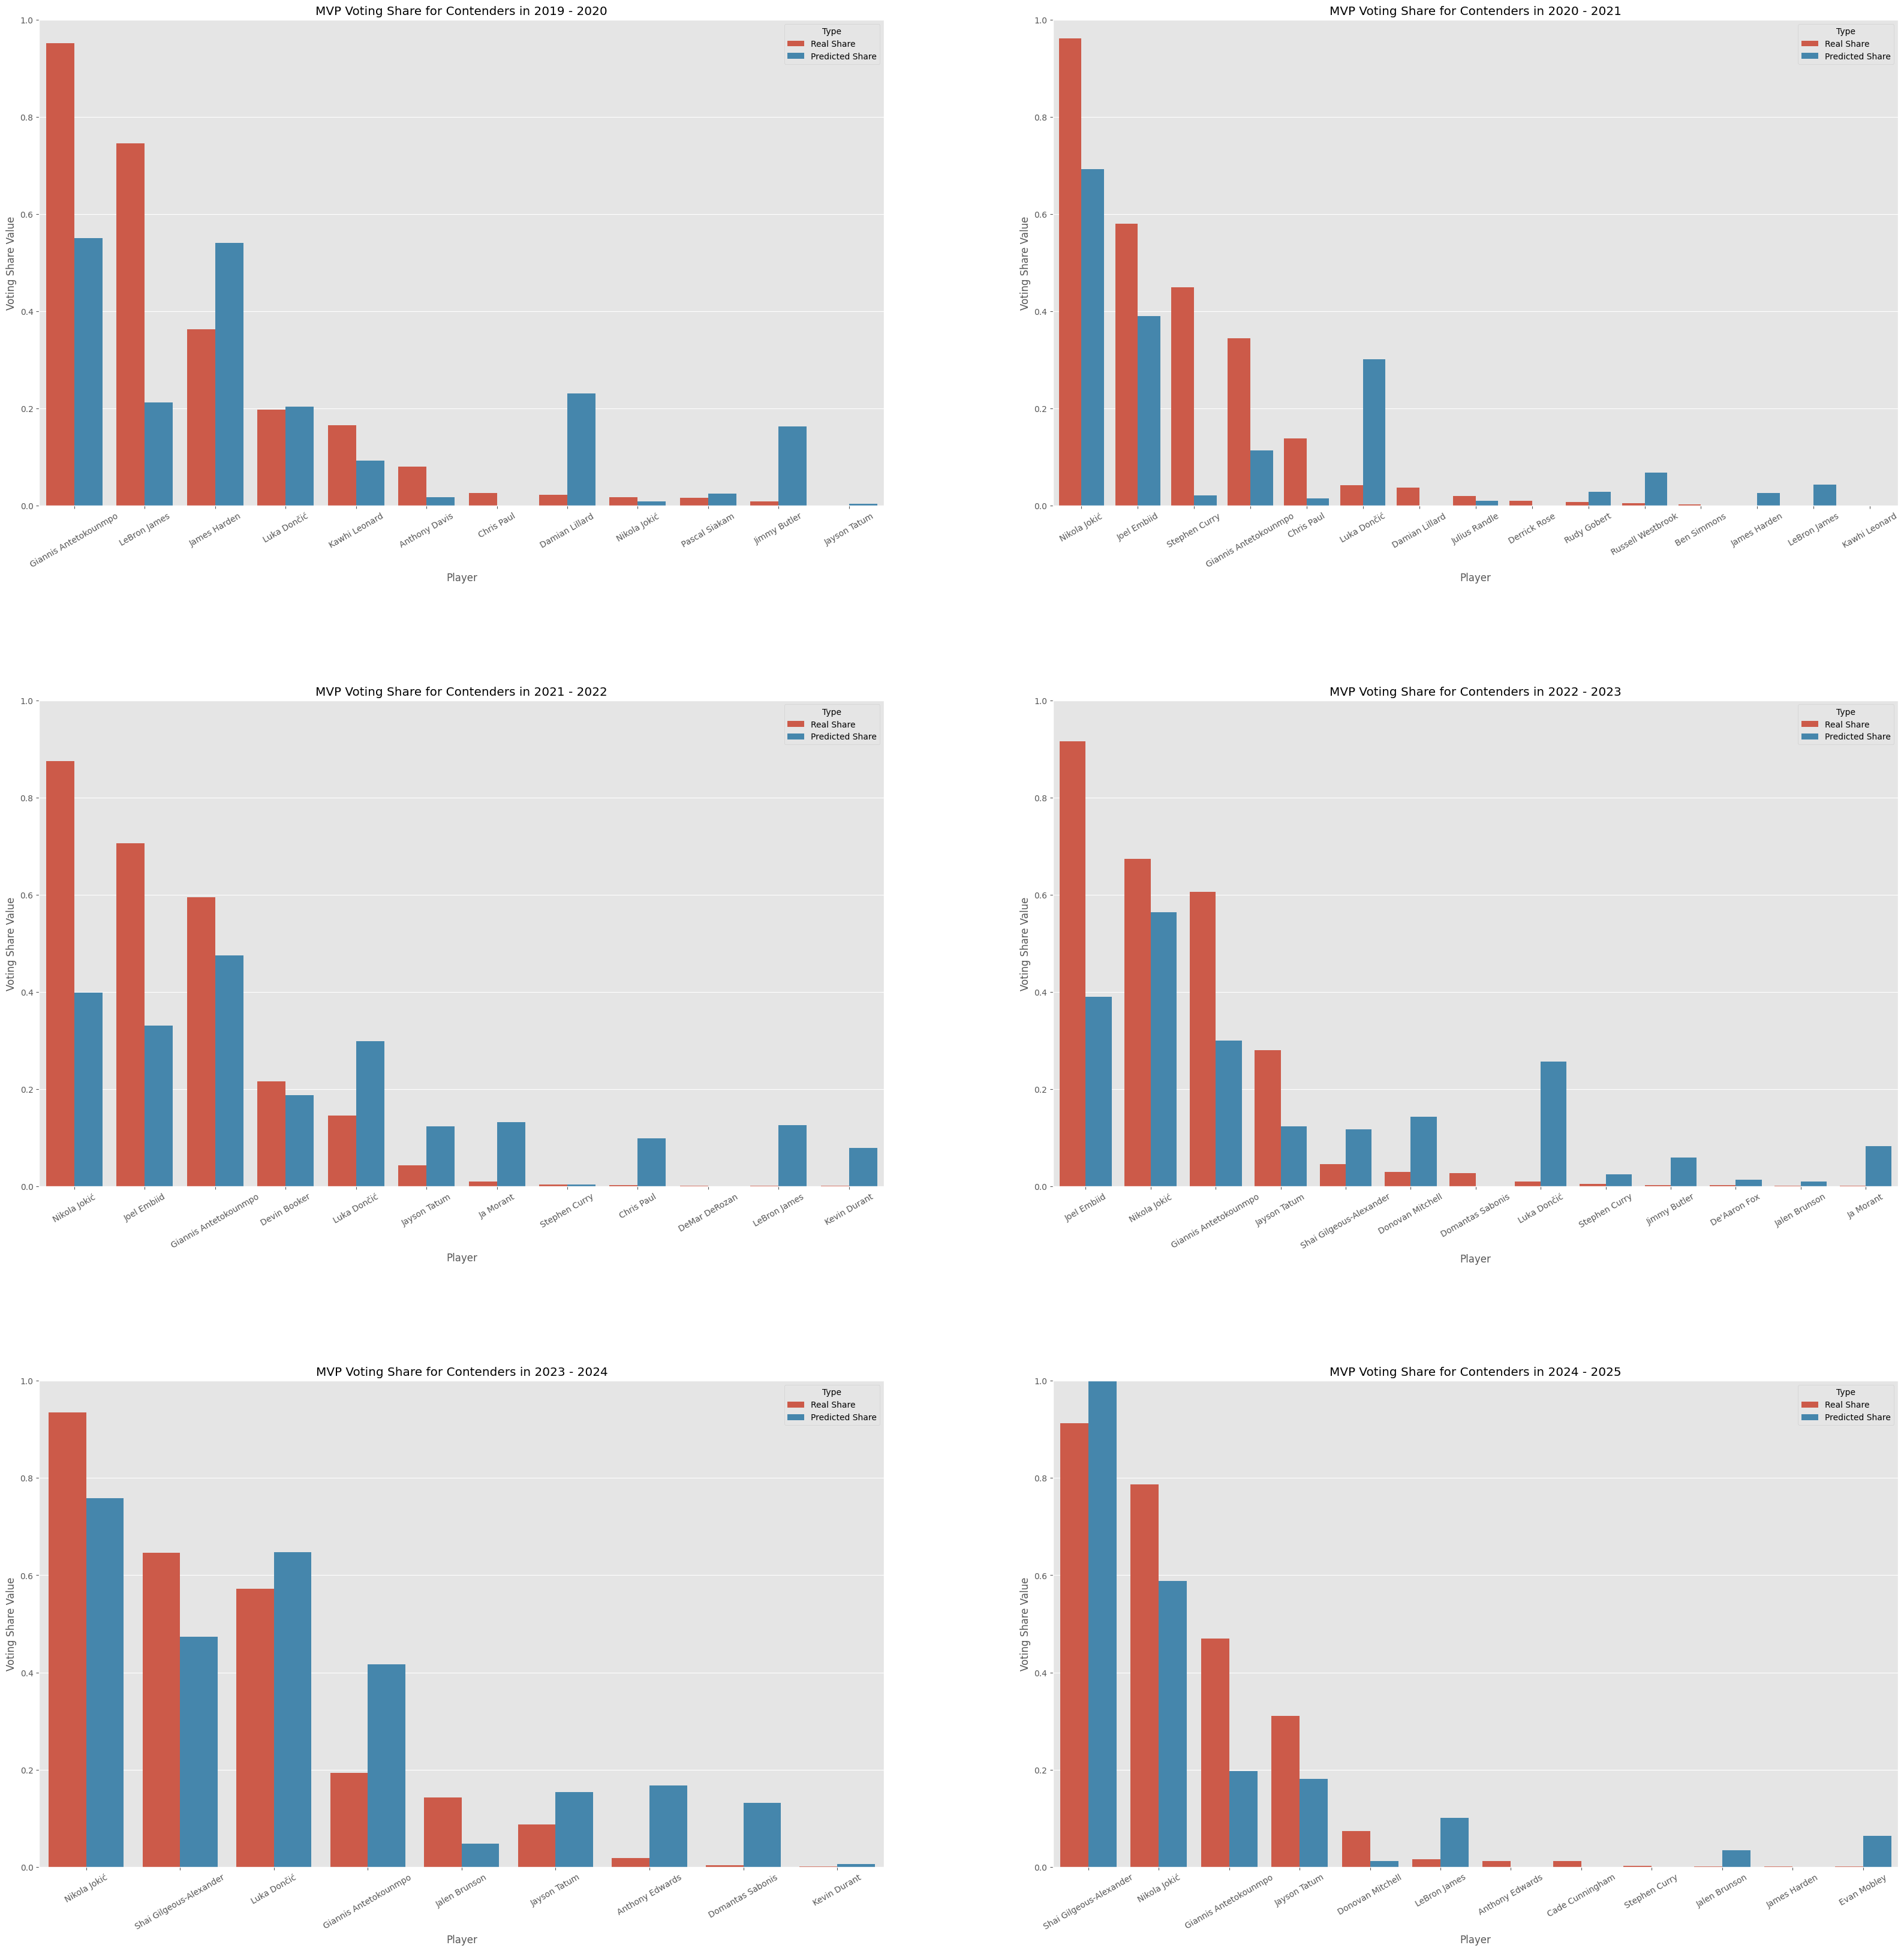

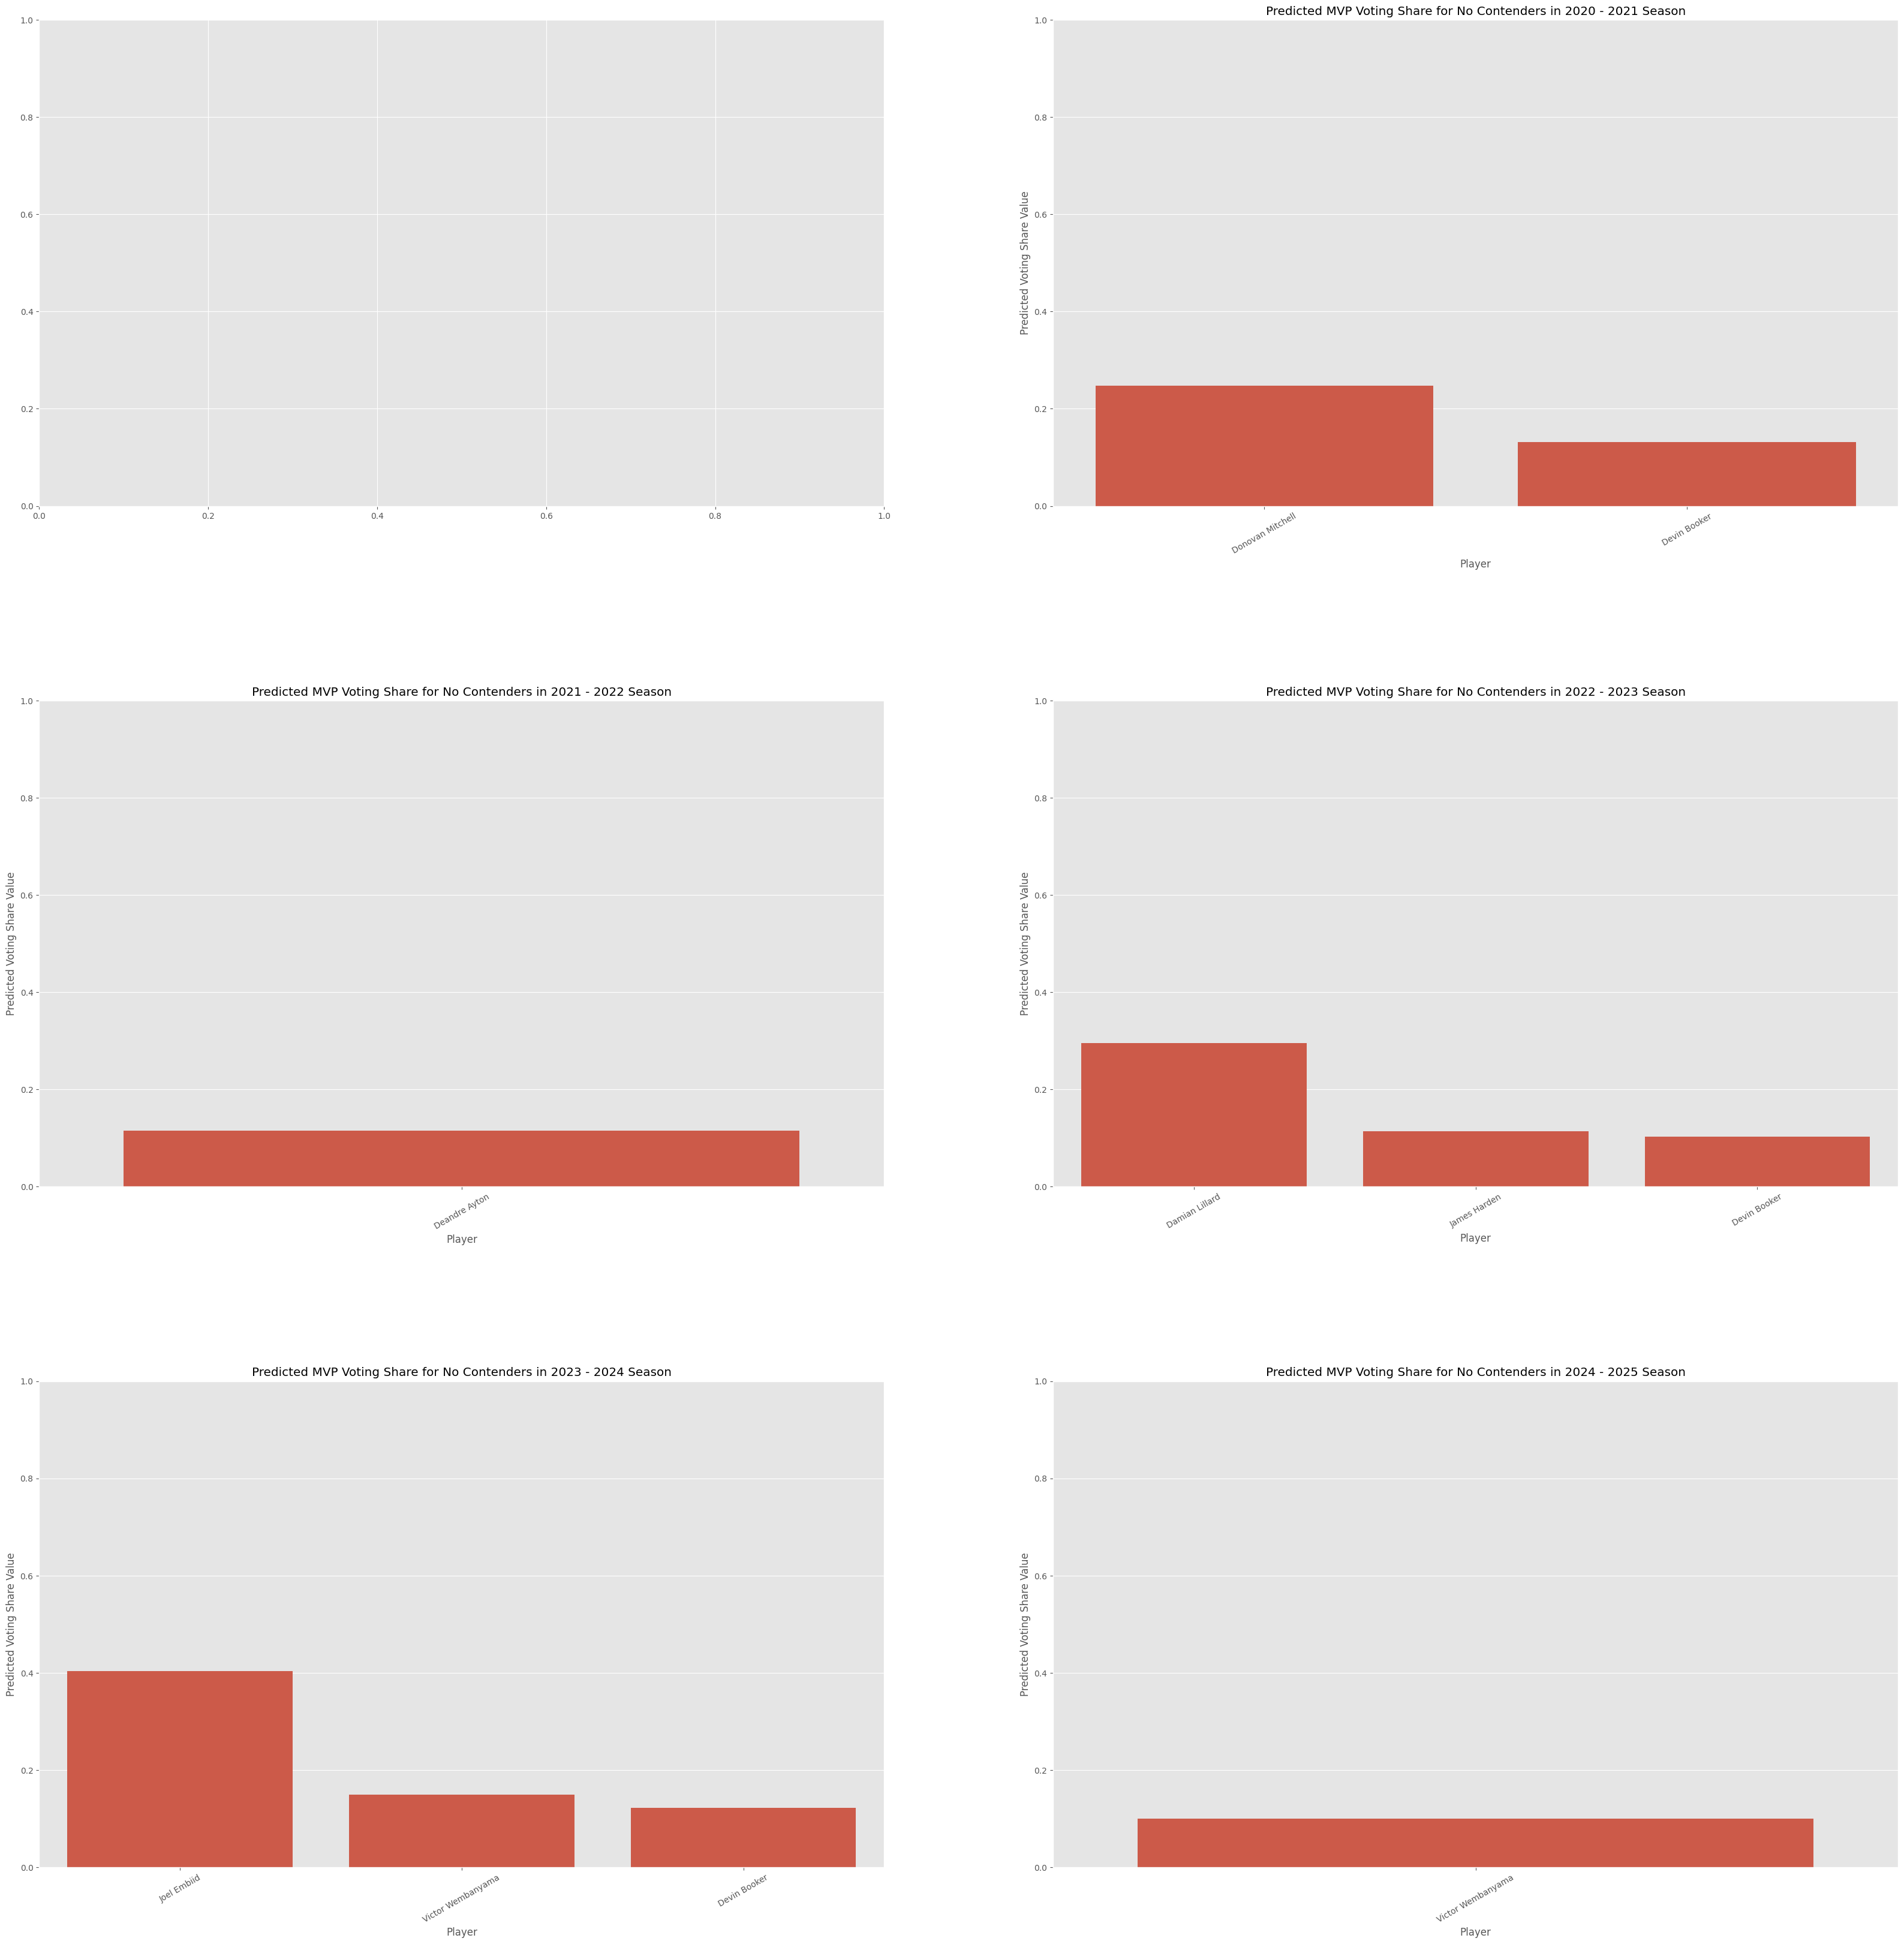

In [32]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])